# Dealing with Bias and Variance

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from time import time
from addutils import css_notebook
from sklearn import metrics
import sys
import os
from IPython.core.display import Image
css_notebook()


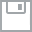
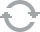
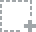
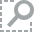
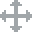
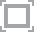
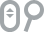
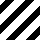
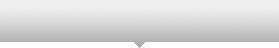
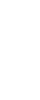
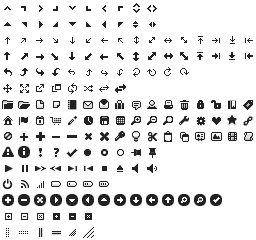
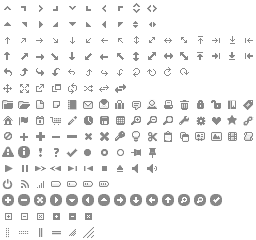
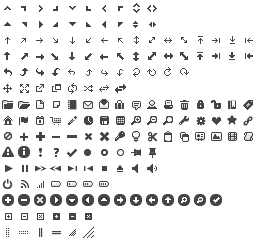
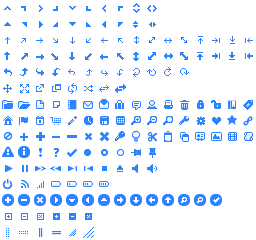
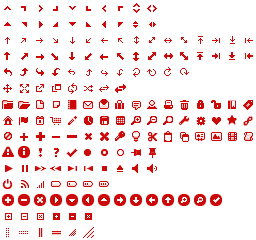
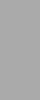
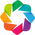
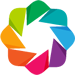

In [3]:
import bokeh.plotting as bk
bk.output_notebook()

## 1 Bias-Variance Tradeoff

### 1.1 (In)Formal introduction to Bias and Variance

Roughly speaking Machine Learning algorithms try to characterize a tradeoff between generalization (how well the model represents the general concept or function to learn) and apporoximation (how well the model fits the data). A small error denotes a good approximation of the function _out of sample_. A more complex model has a better chance of approximating $f$, in contrast a less complex model has a better chance of generalizing (picking the right approximation) out of sample.

A more formal definition can be given after *Hastie, et al. 2009*.
Let's explain Bias-Variance using linear regression problems, and specifically we'll use a squared-error measure as loss function. Assume further that the output $Y = f(X) + \epsilon$ where $E(\epsilon) = 0$ and $Var(\epsilon) = \sigma_\epsilon^2$

We estimate a model $\widehat{f}(X)$ of a function $f(X)$, and the expected squared error of a given point $x_0$ is:

$$Err(x_0) = E[(Y - \widehat{f}(x_0))^2]$$

It is possible to decompose this error in its Bias and Variance components:

$$Err(x_0) = \big(E[\widehat{f}(x_0)] - f(x_0)\big)^2 + E\big[\widehat{f}(x_0) - E[\widehat{f}(x_0)]\big]^2 + \sigma_{\epsilon}^2$$

$$Err(x_0) = Bias^2 + Variance + Irreducible Error$$

Where $Irreducible Error$ is the variance in the true relationship that cannot be captured by any model no matter how well we estimate $f(X)$. $Bias^2$ is the difference between the average of our estimate from the true mean. $Variance$ is the expected squared deviation of $\widehat{f}(x_0)$ around its mean. Usually the more complex is the model the lower the Bias but the higher the variance. We can give a pictorial illustration of the relationship with the image below. (The image is taken from [this](http://scott.fortmann-roe.com/docs/BiasVariance.html) blog)

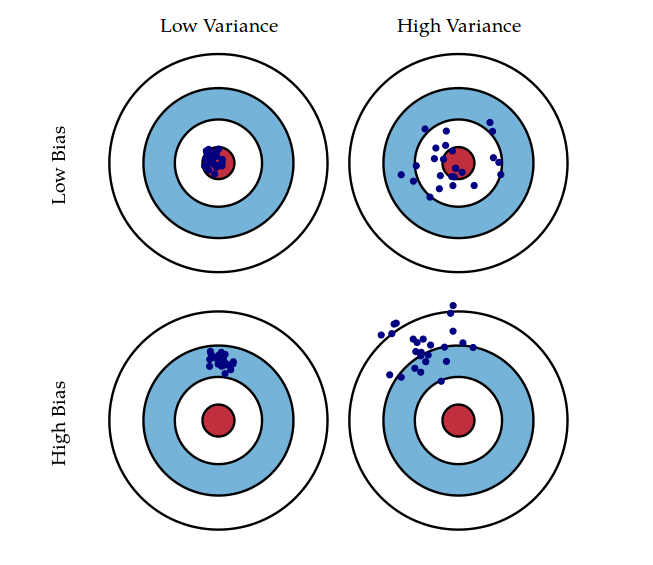

In [4]:
Image('utilities/bias_variance.png') 

Suppose the center (red) of each diagram is the real function to learn. As we move away from the center the prediction gets worse and worse. Each dot in the picture is a realization of the model given a subsample of the dataset; each circle is a different model (whose particular realizations are the dots) and model's characteristics are described by the two corresponding labels (horizontal and vertical).

Having a model (top left) with both Low Bias and Low Variance is practically impossible since, as we will see next, if we decrese one the other increase (in this case both generalization and approximation will be good and we could learn almost the real function); the hard part is hence finding the best possible balance between the two. In case of Low Bias and High Variance (top right), the model is capable of representing the correct function but the model may be too complex, and thus more supsceptible in variation on the dataset. For this reason each dot (function approximation) draw from this model may vary considerably from estimate to estimate, depending on the particular subsample used for training. For High Bias and Low Variance (bottom left) the model is constantly learning a substantially different function respect to the true one, but each run is independent from the particular subsample of data (it generalize well but it approximate poorly). If we have a model that has both High Varianche and High Bias (bottom right) the model si constantly learning a wrong model with high variability between subsamples and thus the probability of picking a good model is very low. 

One can think of Bias and Variance as urn that contains a bunch of candidate approximations of an unknown function $f$. If we have few candidates in the urn (think about degenerating and have only one function in it), but each candidate is far away from the true value of $f$; in this case the Bias is high and the Variance is low, no matter of the dataset we will always return the same function. If we have a bigger urn containing a lot of candidates the probability that it contains the true function is higher, but it is difficult to navigate through the candidates to find the right one. In this case the Bias is lower but the Variance is higher, we have so many varieties that depending on which sample we get the function differs.

Next we will show what we mean by complexity of the model with some practical examples in order to further understand the Bias-Variance tradeoff.

In [5]:
sys.path.append(os.getcwd() + "/utilities")
import biasvariance
from bokeh.models.ranges import Range1d

In this figure, we use polynomials with different degrees `d` to fit the same data.

For `d=1`, the model suffers from **high bias**: the model complexity is not enough to represent the data.

At the other extreme, for `d=6` the model suffers from **high variance**: the mode overfit the data because it has too many free parameters.  In this case a typical behaviour is that if any of the input points are varied slightly, it could result in a very different approximation. This kind of model will fit perfectly the training data while failing to do so on validation data.

In the middle picture, for `d=2`, we have found a good model.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
biasvariance.plot_bias_variance(8, random_seed=42, err=10)

### 1.2 Bias-Variance Tradeoff explained with a regression example

In this section we will explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We consider the situation where we have only 2 data points: 

In [8]:
from sklearn import linear_model
X = np.array([0.5, 1.0]).reshape(2,1)
y = np.array([0.5, 1.0])
X_test = np.array([0.0, 2.0]).reshape(2,1)
regr = linear_model.LinearRegression()
regr.fit(X, y)
fig = bk.figure(plot_width=400, plot_height=300, title=None)
fig.circle(X[:,0], y, size=5)
fig.line(X_test[:,0], regr.predict(X_test), color='green')
bk.show(fig)

In real life situation, we have noise (e.g. measurement noise) in our data:

In [11]:
import seaborn as sns
import addutils.palette as pal
import random
cat_colors = list(map(pal.to_hex, sns.color_palette('bright', 6)))
random.shuffle(cat_colors)

In [12]:
np.random.seed(0)
fig = bk.figure(plot_width=400, plot_height=300, title=None)

for i in range(6):
    noise = np.random.normal(loc=0, scale=.1, size=X.shape)
    noisy_X = X + noise
    regr.fit(noisy_X, y)
    
    fig.circle(noisy_X[:,0], y, size=8, fill_color=cat_colors[i], line_color='black')
    fig.line(X_test[:,0], regr.predict(X_test), color=cat_colors[i])
bk.show(fig)

As we can see, our linear model captures and amplifies the noise in the data. It displays a lot of variance. This means that if we subsample the data and we fit a different model to each subsample (each pair of points) we obtain a model that differ substantially from the true model. There are several techniques to reduce variance. **Regularization** is one of those, it is a way to change the tradeoff between Bias and Variance by putting more weights on either one. We will briefly use it in this example while we leave a more detailed explanation for the next section.

We can use another linear estimator that uses **regularization**: the Ridge estimator. This estimator regularizes the coefficients by shrinking them to zero, under the assumption that very high correlations are often spurious. High alphas give high regularization (shrinkage):

In [13]:
regr = linear_model.Ridge(alpha=0.08)

fig = bk.figure(plot_width=400, plot_height=300, title=None)
for i in range(6):
    noise = np.random.normal(loc=0, scale=.1, size=X.shape)
    noisy_X = X + noise
    regr.fit(noisy_X, y)
    fig.circle(noisy_X[:,0], y, size=8, color=cat_colors[i], line_color='black')
    fig.line(X_test[:,0], regr.predict(X_test), color=cat_colors[i])
bk.show(fig)

As we can see, the estimator displays much less variance. However it systematically under-estimates the coefficient. It displays a biased behavior. As explained earlier we changed the tradeoff between Bias and Variance with regularization. Changing one quantity (for example decreasing Variance) inevitably increases the other (Bias). 

With the next examples we will try to answer the following question: **If our estimator is underperforming, how should we move forward?**

- Do I need a Simple or more Complicated Model ?
- Do I need More Training Samples ?
- Do I need more features for each observed data point ?

The answer is often counter-intuitive. In particular, **Sometimes using a more complicated model will give _worse_ results.**  Also, **Sometimes adding training data will not improve your results.**  The ability to determine what steps will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

## 2 Regularization: what it is and why it is necessary

**The core idea behind regularization is that we are going to prefer models that are simpler**, even if they lead to more errors on the training set. We start by defining a 9th order polynomial function. This represents our 'ground truth'. You can imagine it like a signal measured at diffrent times:

In [14]:
f = lambda t: 1.2*t**2 + 0.1*t**3 - 0.6*t**5 - 0.8*t**9
gt_coeff = [0, 0, 1.2, 0.1, 0., -0.6, 0., 0., 0., -0.8]

Unfortunately in real life situation every signal is affected by a measurement error; in this example we simulate it with the variable `noise_level`. Our ground truth is a 9th order polynomial.

At first it would seem an obvius choice to use a 9th order polynomial to fit the signal. If you play a little with the following code you will discover that not using a regularization technique (`LinearRegression` doesn't allow any regularization), most of the time could be a bad choice, and a simpler (lower-order) model it is much better to avoid overfitting.

Try to change the following variables:

* `orders`: orders of the polynomials to fit
* `n_samples`: when the number of the samples is small it's difficult to fit a high-order model and you have overfitting
* `noise_level`: whit very low noise it's easier to fit higher-order polynomials

*Keep in mind that we didn't fix the random generator seed, so every time you run the cell you'll have a different noise distribution on the samples*.

**As you can see we use a linear algorithm to fit a nonlinear function, this is possible because we use the linear algorithm to fit the nonlinear coefficients that we define in the regressors**.

In [31]:
tmin, tmax = -1.1, 1.0
n_samples = 25
noise_level = 0.2
orders = [4, 9]
np.random.seed(1)
t = tmin + np.random.rand(n_samples) * (tmax-tmin)              # Sample points
y_noisy = f(t) + noise_level*np.random.normal(size=n_samples)   # Noisy measure

fig = bk.figure(plot_width=700, plot_height=400,
                title='4th and a 9th order polynomial with Ground truth')
fig.circle(t, y_noisy, size=8, fill_alpha=0.4)

p = np.linspace(tmin, tmax, 200)                                # Array to calc. the prediction
colors = ['royalblue', 'green']
for order in orders:
    X = np.array([t**i for i in range(order+1)]).T              # Regressor
    Xp = np.array([p**i for i in range(order+1)]).T             # Regressor for prediction
    poly_linreg = linear_model.LinearRegression().fit(X, y_noisy)
    fig.line(p, poly_linreg.predict(Xp), legend='linreg order: %02i' % order,
             color=colors.pop(), line_width=3.0)

fig.line(p, f(p), legend="truth", color='red', line_width=4.0)
fig.legend.label_text_font_size = '14pt'
fig.legend.orientation = 'top_left'
np.set_printoptions(precision=2)
print('Ground Truth coeff.: ', ' '.join(['%+5.1f' %n for n in gt_coeff]))
print('LinReg coefficients: ', ' '.join(['%+5.1f' %n for n in poly_linreg.coef_]))
bk.show(fig)

Ground Truth coeff.:   +0.0  +0.0  +1.2  +0.1  +0.0  -0.6  +0.0  +0.0  +0.0  -0.8
LinReg coefficients:   +0.0  -0.9  +4.3 +11.6 -18.2 -42.8 +35.3 +61.7 -21.4 -31.9


Now we compare the previous `LinearRegression` algorithm with the `Lasso` algorithm.

`Lasso` (least absolute shrinkage and selection operator) is an alternative regularized version of least squares: it is a **shrinkage estimator**: unlike `ridge regression`, as the penalty term increases, lasso sets more coefficients to zero, this means that the lasso estimator produces smaller models.

In [32]:
order = 9
np.random.seed(1)
X = np.array([t**i for i in range(order+1)]).T
Xp = np.array([p**i for i in range(order+1)]).T
poly_linreg = linear_model.LinearRegression().fit(X, y_noisy)
poly_lasso = linear_model.Lasso(alpha = 0.005).fit(X, y_noisy)

fig = bk.figure(plot_width=700, plot_height=400)
fig.circle(t, y_noisy, size=8, alpha=0.4)
fig.line(p, poly_linreg.predict(Xp), legend='linreg order: %02i' % order,
         color='royalblue', line_width=3.0)
fig.line(p, poly_lasso.predict(Xp), legend='lasso order: %02i' % order,
         line_width=3.0, color='green')
fig.line(p, f(p), legend="truth", color='red', line_width=4.0)

fig.legend.label_text_font_size = '15pt'
fig.legend.orientation = 'top_left'
fig.title = '9th order LinReg and Lasso with Ground truth'

np.set_printoptions(precision=2)
print('Ground Truth coeff.: ', ' '.join(['%+5.1f' %n for n in gt_coeff]))
print('LinReg coefficients: ', ' '.join(['%+5.1f' %n for n in poly_lasso.coef_]))
bk.show(fig)

Ground Truth coeff.:   +0.0  +0.0  +1.2  +0.1  +0.0  -0.6  +0.0  +0.0  +0.0  -0.8
LinReg coefficients:   +0.0  -0.0  +1.0  -0.0  +0.0  -0.0  +0.0  -0.0  +0.0  -1.3


Try by yourself: play a little with the code of the two previous cells by changing `n_samples` and `noise_level` to verify that:

* When `n_samples` is very high (>1000) it's very unlikely to have overfitting. This means that with more data it's possible to fit more complex models without overfitting.
* When `n_samples` is very low (<40) it's almost impossible to fit with Linear Regression without overfitting. In this case regularization is always required
* When `n_samples` is very high (>1000) and `noise_level` is very low, the Lasso algorithm keeps just the coefficients actually used to calculate the ground truth function. This means that Lasso can deal with high dimesional problems where most of the features can be neglected producing compact linear models.

Another way to look at the Bias-Variance tradeoff in previous examples is to consider how the model fits the data. As stated at the beginning of this section when model complexity increases Bias decrease while Variance increses. The optimal model performance is achieved when the level of complexity is such that an increase in Bias is equivalent in reduction of Variance. If the model complexity exceed this threshold we are overfitting (the model is to adapted to the data and does not generalize well) if the model is behind this threshold is said to be underfitting (the model does not fit well the data and it has a poor error for out of sample data).

## 3 Do I need a Simple or a Complex Model?

In order to show the relation between the size of the training dataset and the complexity of the model we generate some example data in the same way we did in the very first example but with more than ten times the number of samples. The we fit a polynomial model and we plot the error w.r.t. the degree of polynomial.

Here **Training Data** are plotted in **Blue** while **Validation Data** are **Red**:

In [33]:
from sklearn import cross_validation
N = 100
test_size = 0.40
error = 1.0
np.random.seed(1)
x = np.random.random(N)
y = biasvariance.test_func(x, error)
x_tr, x_valid, y_tr, y_valid = cross_validation.train_test_split(x, y, test_size=test_size)
fig = bk.figure(plot_width=700, plot_height=400, title=None)
fig.circle(x_tr, y_tr, color='blue', size=6, alpha=0.5)
fig.circle(x_valid, y_valid, color='red', size=6, alpha=0.5)
bk.show(fig)

The **model parameters** *(in our case, the coefficients of the polynomials)* are learned using the **training set**.

The **meta-parameters** *(in our case, the degree of the polynomial)* are adjusted so that this **validation error** is minimized.

Finally, the labels are predicted for the **test set**.

The **validation error** of our polynomial classifier can be visualized by plotting the error as a function of the polynomial degree:

In [34]:
import warnings
warnings.filterwarnings('ignore', message='Polyfit*')

degrees = np.arange(41)
train_err = np.zeros(len(degrees))
validation_err = np.zeros(len(degrees))

for i, d in enumerate(degrees):
    p = np.polyfit(x_tr, y_tr, d)
    train_err[i] = biasvariance.compute_error(x_tr, y_tr, p)
    validation_err[i] = biasvariance.compute_error(x_valid, y_valid, p)

fig = bk.figure(plot_width=700, plot_height=400, title=None)

fig.line(degrees, validation_err,
         line_width=2, legend='cross-validation error', color='royalblue')
fig.line(degrees, train_err, line_width=2, legend='training error', color='green')
fig.line([0, 20], [error, error], line_dash='dashed', legend='intrinsic error', color='black')

fig.xaxis.axis_label = 'degree of fit'
fig.yaxis.axis_label = 'rms error'

fig.grid.grid_line_color = None

bk.show(fig)

For this toy dataset, error = 1.0 is the best we can hope to obtain. Choosing `d=6` in this case gets us very close to the optimal error.

Notice that in the above plot, `d=6` gives the best results. But in the very first example, we found that `d=6` vastly over-fits the data. What’s going on here? The difference is the **number of training points** used:

**As a general rule of thumb, the more the training points, the more complex the model can be.**

## 4 Do I need More Training Samples?

In order to exploit the relationship outlined above, between the complexity of the model and the number of examples, we use a tool called **Learning Curves**. Learning Curves works by plotting the training error and validation (or test) error as a **function of the number of training points**:

In [35]:
def plot_learning_curve(d, N=100, y_range=None):
    test_size = 0.40
    n_sizes = 50       # Number of testing point in which to split the size
    n_runs = 20        # Number of times to run the test for each training set size
    sizes = np.linspace(2, N, n_sizes).astype(int)
    train_err = np.zeros((n_runs, n_sizes))
    validation_err = np.zeros((n_runs, n_sizes))
    for run in range(n_runs):
        for nsize, size in enumerate(sizes):
            x_tr, x_valid, y_tr, y_valid = cross_validation.train_test_split(x, y,
                                           test_size=test_size, random_state=run)
            # Train on only the first `size` points
            p = np.polyfit(x_tr[:size], y_tr[:size], d)
            # Validation error is on the *entire* validation set
            validation_err[run, nsize] = biasvariance.compute_error(x_valid, y_valid, p)
            # Training error is on only the points used for training
            train_err[run, nsize] = biasvariance.compute_error(x_tr[:size], y_tr[:size], p)

    fig = bk.figure(plot_width=400, plot_height=300, title='d = %i' % d,
                    x_range=(0, N-1)) 
    fig.title_text_font_size = '11pt'
    fig.xaxis.axis_label_text_font_size = '9pt'
    fig.yaxis.axis_label_text_font_size = '9pt'
    
    fig.line(sizes, validation_err.mean(axis=0), 
             line_width=2, legend='mean validation error', color='royalblue')
    fig.line(sizes, train_err.mean(axis=0),
             line_width=2, legend='mean training error', color='green')
    fig.line([0, N], [error, error],
             line_dash='dashed', legend='intrinsic error', color='black')
    
    fig.xaxis.axis_label = 'traning set size'
    fig.yaxis.axis_label = 'rms error'
    fig.legend.orientation = 'top_right'
    
    if y_range:
        fig.y_range = Range1d(y_range[0], y_range[1])

    fig.grid.grid_line_color = None
    bk.show(fig)

Now we look at the behavior of <font color="royalblue">$E_{train}$</font> and <font color="red">$E_{test}$</font>.

<font color="red">As we increase $N$, $E_{test}$ decreases</font> until the limit of the algorithm, that is its $Bias$.

<font color="royalblue">As we increase $N$, $E_{train}$ increases</font>, because with few datapoints the task is simpler, while adding more data increase the difficulty of the algorithm to fit them.

The discrepancy of the two curves is the **generalization error**. It should shrink and get tighter as generalization increases.

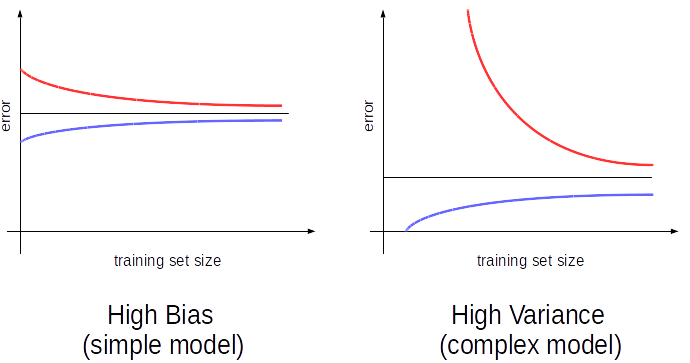

In [36]:
Image('utilities/learning_curves.png') 

In the left picture (simple model) we can see that the model "true" error (the best the model can do) is high and pretty soon (that is for lower values of $N$) we reach the point were both $E_{train}$ and $E_{test}$ are closer. In the right picture (complex model) we can see that, since it is more complex, it has a better approximation of the target function and thus can achieve (in principle) a lower $E_{test}$ error. The function is so complex that with few data points it fits them perfectly reaching a training error of zero. However if we look at the corresponding $E_{test}$ we can see that it is very high, we haven't learn anything. As the number of examples grows, $E_{test}$ starts lowering and it gets lower than the other model, but the discrepancy between the two errors remains higher than that of the previous example. 

Let's see a practical example:

In [37]:
plot_learning_curve(d=1, N=100)

A polynomial model with `d=1` is a **high-biased estimator** which under-fits the data. This is indicated by the fact that **both the training and validation errors are very high**.

*Adding more data WON'T work in this case.*

**When both TRAINING and VALIDATION curves converge to an high error, we have a HIGH BIAS model.** In this situation we can try one of the following actions:

* Using a more sophisticated model (i.e. in this case, increase ``d``)
* Gather more features for each sample.
* Decrease regularlization.

Now let's look at a model with higher degree (and thus higher variance):

In [38]:
plot_learning_curve(d=10, N=100, y_range=(0,12))

In this example it is possible to see that with `d=10` a **high-variance** estimator may **overfit data** when the number of samples is not sufficent. It is possible to note it by looking at the discrepancy between the two curves. When the number of samples is low we have a low training error, but the corresponding test error is really high. As the number of samples increase the test error decrease and converge to the model error but it may be to slow to converge and still have an higher discrepancy between the two curves.

**When the learning curves does not converge using the full training set, it indicates a HIGH VARIANCE model, and the model is OVERFITTING the data.**

A high-variance model can be improved by:

* Gathering more training samples.
* Using a less-sophisticated model (i.e. in this case, make `d` smaller)
* Increase regularization.

*In particular, gathering more features for each sample will not help the results.*

## 6 Do the right thing

### 6.1 High Bias

If our algorithm shows high **bias**, the following actions might help:

- **Add more features**. In our example of predicting home prices,
  it may be helpful to make use of information such as the neighborhood
  the house is in, the year the house was built, the size of the lot, etc.
  Adding these features to the training and test sets can improve
  a high-bias estimator
- **Use a more sophisticated model**. Adding complexity to the model can
  help improve on bias. For a polynomial fit, this can be accomplished
  by increasing the degree d. Each learning technique has its own
  methods of adding complexity.
- **Use fewer samples**. Though this will not improve the classification,
  a high-bias algorithm can attain nearly the same error with a smaller
  training sample. For algorithms which are computationally expensive,
  reducing the training sample size can lead to very large improvements
  in speed.
- **Decrease regularization**. Regularization is a technique used to impose
  simplicity in some machine learning models, by adding a penalty term that
  depends on the characteristics of the parameters. If a model has high bias,
  decreasing the effect of regularization can lead to better results.

### 6.2 High Variance

If our algorithm shows **high variance**, the following actions might help:

- **Use fewer features**. Using a feature selection technique may be
  useful, and decrease the over-fitting of the estimator.
- **Use a simpler model**.  Model complexity and over-fitting go hand-in-hand.
- **Use more training samples**. Adding training samples can reduce
  the effect of over-fitting, and lead to improvements in a high
  variance estimator.
- **Increase Regularization**. Regularization is designed to prevent
  over-fitting. In a high-variance model, increasing regularization
  can lead to better results.

These choices become very important in real-world situations. For example,
due to limited telescope time, astronomers must seek a balance between
observing a large number of objects, and observing a large number of
features for each object. Determining which is more important for a
particular learning task can inform the observing strategy that the
astronomer employs. In a later exercise, we will explore the use of
learning curves for the photometric redshift problem.

### 6.3 More Sophisticate Methods

There are a lot more options for performing validation and model testing.
In particular, there are several schemes for cross-validation, in which
the model is fit multiple times with different training and test sets.
The details are different, but the principles are the same as what we've
seen here.

For more information see the ``sklearn.cross_validation`` module documentation,
and the information on the scikit-learn website.

### 6.4 One Last Caution

Using validation schemes to determine hyper-parameters means that we are
fitting the hyper-parameters to the particular validation set.  In the same
way that parameters can be over-fit to the training set, hyperparameters can
be over-fit to the validation set.  Because of this, the validation error
tends to under-predict the classification error of new data.

For this reason, it is recommended to split the data into three sets:

- The **training set**, used to train the model (usually ~60% of the data)
- The **validation set**, used to validate the model (usually ~20% of the data)
- The **test set**, used to evaluate the expected error of the validated model (usually ~20% of the data)

*This may seem excessive, and many machine learning practitioners ignore the need
for a test set.  But if your goal is to predict the error of a model on unknown
data, using a test set is vital*.

## 7 Additional examples on Regularization: Ridge Regression and Stocastic Gradient Descent (SGD)

`LinearRegression` fits a linear model with coefficients $w = (w_1, \ldots, w_p)$ to minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation.

Mathematically it solves a problem of the form: 
<!-- <img src='files/utilities/ols_problem.png' > -->
$$ \underset{w}{min} \|Xw -y\|_2^2$$

Let's see the `diabetes` dataset:

In [39]:
from sklearn import datasets
diabetes = datasets.load_diabetes() # Diabetes is a dataset with 442 samples and 10 attributes
X = pd.DataFrame(diabetes.data)
y = pd.DataFrame(diabetes.target)

warnings.filterwarnings("ignore", category=DeprecationWarning)
X[X.columns[0:7]].head()            # Show the first 3 attributes for the first 7 samples

,0,1,2,3,4,5,6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142


In [40]:
X[X.columns[0:7]].describe()       # Describe the first three columns

,0,1,2,3,4,5,6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01


In [44]:
list(zip(X.columns, [type(x) for x in X.ix[0,:]]))  # Check the datatypes of the columns)

[(0, numpy.float64),
 (1, numpy.float64),
 (2, numpy.float64),
 (3, numpy.float64),
 (4, numpy.float64),
 (5, numpy.float64),
 (6, numpy.float64),
 (7, numpy.float64),
 (8, numpy.float64),
 (9, numpy.float64)]

Keep just the attributes in the column number 2 (3rd column) and use 25% of the data as a testing set:

In [45]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(np.array(X[X.columns[2:3]]),\
                                                                     np.array(y),\
                                                                     test_size=0.25, random_state=0)


In [46]:
regr1 = linear_model.LinearRegression().fit(X_train, y_train)

fig = bk.figure(plot_width=640, plot_height=300, title=None)
fig.circle(X_test[:,0], y_test[:,0], color='black')
fig.line(X_test[:,0], regr1.predict(X_test)[:,0], color='blue',
         legend='linear regression', line_width=3)
fig.legend.orientation = 'bottom_right'
bk.show(fig)

### 7.1 Ridge Regression

Linear Regression rely on the independence of the model terms. When terms are correlated and the columns of the design matrix $X$; have an approximate linear dependence, the matrix $(X^TX)^{-1}$ <!--(&Chi;<sup>T</sup>&Chi;)<sup>-1</sup>--> becomes
close to singular. As a result, the least-squares estimate becomes highly sensitive to random errors in the observed response *y*, producing a large variance. This situation of multicollinearity can arise, for example, when data are collected without an experimental design.

The ridge coefficients minimize a penalized residual sum of squares:

$$ \underset{w}{min} \|Xw -y\|_2^2 + \alpha \|w\|_2^2$$
<!-- <img src='files/utilities/penalized_residuals_sum_of_squares.png'> -->

Here, positive $\alpha  \geq 0 \hspace{2 pt}$ is a complexity parameter that controls the amount of shrinkage: the larger the value of $\alpha$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity.

In [47]:
regr2 = linear_model.Ridge(alpha = 0.5)
regr2.fit(X_train, y_train)

fig = bk.figure(plot_width=640, plot_height=330, title=None)
fig.circle(X_test[:,0], y_test[:,0], color='black')
fig.line(X_test[:,0], regr1.predict(X_test)[:,0], color='blue',
         legend='linear regression', line_width=3)
fig.line(X_test[:,0], regr2.predict(X_test)[:,0], color='red',
         legend='ridge regression', line_width=3)
fig.legend.orientation = 'bottom_right'
bk.show(fig)

Keep all the 10 attributes and split training and testing sets:

In [29]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(np.array(X),\
                                                                     np.array(y),\
                                                                     test_size=0.25, 
                                                                     random_state=0)


Fit the ridge regressor on all the attributes and calculate the fits for a given $\alpha$

In [50]:
regr3 = linear_model.Ridge(alpha = 0.6)
regr3.fit(X_train, y_train)
print('Coefficients: ', regr3.coef_[0][0])
print('Variance score: %.2f' % regr3.score(X_test, y_test))

Coefficients:  575.633255615
Variance score: 0.19


The larger the value of $\alpha  \geq 0 \hspace{2 pt}$, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity. Nevertheless, the value of $\alpha \hspace{2 pt}$ cannot be increased indefinitely: there is an optimal point above which the variance scores and residual sum of squales drop sharply:

In [51]:
n_alphas = 200
alphas = np.logspace(-5, 1, n_alphas)
regr3 = linear_model.Ridge(fit_intercept=False)

scores = []
for a in alphas:
    regr3.set_params(alpha=a)
    regr3.fit(X_train, y_train)
    scores.append(regr3.score(X_test, y_test))

fig = bk.figure(plot_width=640, plot_height=330,
                title=r'Variance Scores as a function of alpha',
                x_axis_type='log', x_range=(min(alphas), max(alphas)))
fig.title_text_font_size = '11pt'
fig.xaxis.axis_label = 'alpha'
fig.yaxis.axis_label = 'scores'
fig.axis.axis_label_text_font_size = '10pt'
fig.line(alphas, scores, line_color='blue')
bk.show(fig)

### 7.2 Stochastic Gradient Descent (SGD)

`Stochastic Gradient Descent` is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. Given that the data is sparse, the classifiers in this module easily scale to problems with more than $10^5$ training examples and more than $10^5$ features.

In [52]:
from sklearn.datasets.samples_generator import make_regression

X, y = make_regression(n_samples=100000, n_features=1, n_informative=1,\
                        random_state=0, noise=35)

reg3 = linear_model.SGDRegressor(alpha=0.1, n_iter=20)
reg3.fit(X, y)

fig = bk.figure(plot_width=630, plot_height=300, title=None)
fig.circle(X[::1000, 0], y[::1000],  color='black')
fig.line(X[::1000, 0], reg3.predict(X[::1000]), color='red', line_width=3)
fig.grid.grid_line_color = None
fig.axis.minor_tick_out = 0
bk.show(fig)

### 7.2 Support Vector Machines


**TODO:** aggiungere SVM

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.